
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [2]:
import pandas as pd
import numpy as np
import torch

from tqdm import tqdm

from transformers import AutoTokenizer, AutoModel

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

In [66]:
#Dropout: 0, 10%
DROPOUT = 0.10

#Learning rate: 2.5e-5, 5e-5
LEARNING_RATE = 5e-5

In [4]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModel.from_pretrained("xlm-roberta-base")

In [5]:
df = pd.read_csv('../datasets/buscape_preprocessed.csv')

In [6]:
df.shape

(133632, 2)

In [7]:
df.head(3)

,review_text,rating
0,estou muito satisfeito o visor e melhor do que...,1
1,muito boa o que gostei preco o que nao gostei ...,1
2,rapida otima qualidade de impressao e facil de...,1


In [33]:
#reviews_batch_01, reviews_batch_02, labels_batch_01, labels_batch_02 = train_test_split(df['review_text'], df['rating'], test_size=0.5, random_state=42)

In [34]:
#print(f'batch_01: {reviews_batch_01.shape[0]} instancias')
#print(f'batch_02: {reviews_batch_02.shape[0]} instancias')

batch_01: 66816 instancias
batch_02: 66816 instancias


In [8]:
df['rating'].value_counts()

rating
1    66816
0    66816
Name: count, dtype: int64

In [9]:
reviews = df['review_text']
labels = df['rating']

#### Tokenização e geração dos embeddings
- Este processo pode demorar alguns instantes para ser concluído

In [11]:
embeddings = []
for review in tqdm((reviews), desc="Processing"):
    inputs = tokenizer(str(review), return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        output = model(**inputs)
    embeddings.append(output.last_hidden_state.mean(dim=1).numpy())

Processing: 100%|██████████| 133632/133632 [6:04:10<00:00,  6.12it/s]  


In [12]:
embeddings_array = np.vstack(embeddings)

In [13]:
print(f'{embeddings_array.shape[0]} embeddings de {embeddings_array.shape[1]} dimensões')

133632 embeddings de 768 dimensões


#### Feature based 1

In [15]:
additional_features = np.array([[len(str(review).split())] for review in reviews])

In [16]:
print(embeddings_array.shape)
print(additional_features.shape)

(133632, 768)
(133632, 1)


#### Combinando embeddings_array e additional_features

In [17]:
combined_features = np.hstack((embeddings_array, additional_features))

#### Dividindo dataset treino e teste

In [18]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

In [20]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)

2023-08-20 16:13:58.225814: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 328839780 exceeds 10% of free system memory.


In [21]:
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

2023-08-20 16:14:06.949194: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 82212252 exceeds 10% of free system memory.


#### Arquitetura rede neural MLP

In [67]:
model = Sequential([
    Dense(24, activation='relu', input_dim=X_train_tensor.shape[1]),
    Dropout(DROPOUT),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 24)                18480     
                                                                 
 dropout_4 (Dropout)         (None, 24)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 18,505
Trainable params: 18,505
Non-trainable params: 0
_________________________________________________________________


#### Cross-validation

In [69]:
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

In [70]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

#### Ajustando path para salvar os pesos

In [34]:
CHECKPOINT=ModelCheckpoint(filepath='./weights/tlm_peq_fine_tuning_weights.hdf5', verbose=0, save_best_only=True)
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=3)
CALLBACKS = [CHECKPOINT, EARLY_STOP]

#### Treinamento do modelo

In [35]:
fold = 0

fold_accuracies = []
fold_f1_scores = []

train_loss_history = []
train_accuracy_history = []
for train_indices, val_indices in tqdm((kf.split(combined_features)), desc="Processing"):
    fold+=1
    print(f'fold ---> {fold}')
    X_train_fold = combined_features[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = combined_features[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    # Convertendo dados treino em tensores
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    
    # Convertendo dados de validacao em tensores
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    y_val_fold_tensor = tf.convert_to_tensor(y_val_fold, dtype=tf.float32)
    
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=10, 
        batch_size=32, 
        verbose=0,
        validation_data=(X_val_fold_tensor, y_val_fold_tensor),
        callbacks=CALLBACKS
    )
    
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_binary)
    fold_accuracies.append(fold_accuracy)
    
    fold_f1_score = f1_score(y_val_fold, y_pred_val_binary)
    fold_f1_scores.append(fold_f1_score)
    
    train_loss_history.append(model_history.history['loss'])
    train_accuracy_history.append(model_history.history['accuracy'])
print('Treinamento finalizado!')

fold = 1
Epoch 1/10
3741/3759 [============================>.] - ETA: 0s - loss: 0.5844 - accuracy: 0.7220
Epoch 1: val_loss improved from inf to 0.47536, saving model to ./weights/tlm_peq_fine_tuning_weights.hdf5
3759/3759 [==============================] - 6s 1ms/step - loss: 0.5838 - accuracy: 0.7224 - val_loss: 0.4754 - val_accuracy: 0.7899
Epoch 2/10
3747/3759 [============================>.] - ETA: 0s - loss: 0.4459 - accuracy: 0.8098
Epoch 2: val_loss improved from 0.47536 to 0.42306, saving model to ./weights/tlm_peq_fine_tuning_weights.hdf5
3759/3759 [==============================] - 6s 1ms/step - loss: 0.4458 - accuracy: 0.8098 - val_loss: 0.4231 - val_accuracy: 0.8238
Epoch 3/10
3759/3759 [==============================] - ETA: 0s - loss: 0.4111 - accuracy: 0.8258
Epoch 3: val_loss improved from 0.42306 to 0.40108, saving model to ./weights/tlm_peq_fine_tuning_weights.hdf5
3759/3759 [==============================] - 5s 1ms/step - loss: 0.4111 - accuracy: 0.8258 - val_loss:

In [36]:
print("Media Accuracy:", np.mean(fold_accuracies))
print("Media f1 score:", np.mean(fold_f1_scores))

Media Accuracy: 0.8703831154669188
Media f1 score: 0.8736028062623491


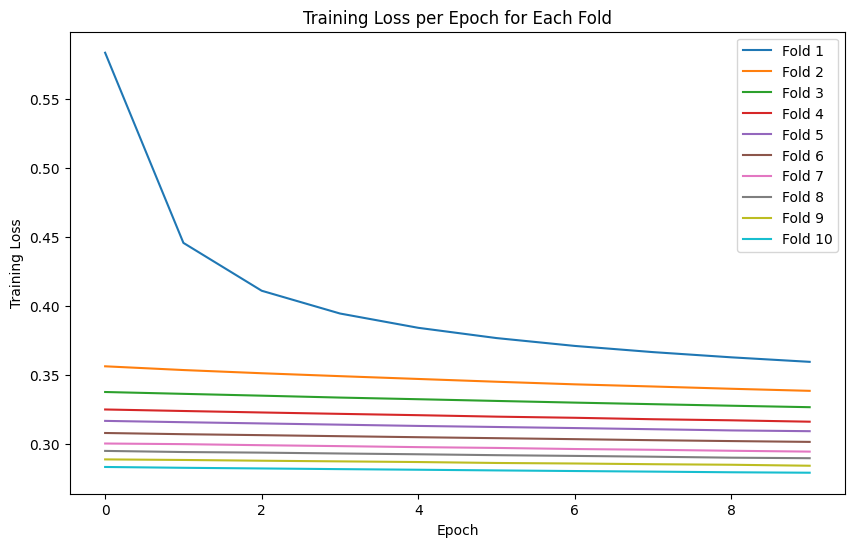

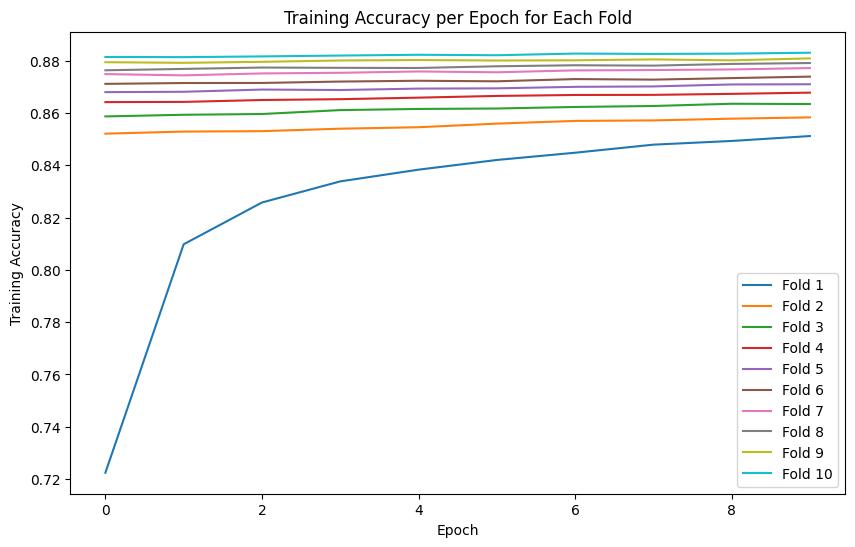

In [37]:
plt.figure(figsize=(10, 6))
for fold_num, fold_loss in enumerate(train_loss_history):
    plt.plot(fold_loss, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Each Fold')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for fold_num, fold_accuracy in enumerate(train_accuracy_history):
    plt.plot(fold_accuracy, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Epoch for Each Fold')
plt.legend()
plt.show()

In [47]:
test_loss, test_accuracy = model.evaluate(X_test_tensor, y_test_tensor)

43/43 [==============================] - 0s 5ms/step - loss: 0.1617 - accuracy: 0.9398


#### Funcao responsavel por carregar os pesos

In [71]:
def load_weights_from_hdf5(model, weight_path):
    model.load_weights(weight_path)
    return model

#### Carregando pesos salvos do treinamento anterior

In [72]:
tlm_peq_weights_path = './weights/tlm_peq_fine_tuning_weights.hdf5'
model = load_weights_from_hdf5(model, tlm_peq_weights_path)

#### Treinamento com fine tuning

In [73]:
fold = 0

fold_accuracies = []
fold_f1_scores = []

train_loss_history = []
train_accuracy_history = []
for train_indices, val_indices in tqdm((kf.split(combined_features)), desc="Processing"):
    fold+=1
    print(f'fold ---> {fold}')
    
    X_train_fold = combined_features[train_indices]
    y_train_fold = np.array(labels)[train_indices]
    
    X_val_fold = combined_features[val_indices]
    y_val_fold = np.array(labels)[val_indices]
    
    # Convertendo dados treino em tensores
    X_train_fold_tensor = tf.convert_to_tensor(X_train_fold, dtype=tf.float32)
    y_train_fold_tensor = tf.convert_to_tensor(y_train_fold, dtype=tf.float32)
    
    # Convertendo dados de validacao em tensores
    X_val_fold_tensor = tf.convert_to_tensor(X_val_fold, dtype=tf.float32)
    y_val_fold_tensor = tf.convert_to_tensor(y_val_fold, dtype=tf.float32)
    
    model_history = model.fit(
        X_train_fold_tensor, 
        y_train_fold_tensor, 
        epochs=10, 
        batch_size=32, 
        verbose=0,
        validation_data=(X_val_fold_tensor, y_val_fold_tensor),
        callbacks=CALLBACKS
    )
    
    y_pred_val = model.predict(X_val_fold_tensor)
    y_pred_val_binary = np.round(y_pred_val)
    
    fold_accuracy = accuracy_score(y_val_fold, y_pred_val_binary)
    fold_accuracies.append(fold_accuracy)
    
    fold_f1_score = f1_score(y_val_fold, y_pred_val_binary)
    fold_f1_scores.append(fold_f1_score)
    
    train_loss_history.append(model_history.history['loss'])
    train_accuracy_history.append(model_history.history['accuracy'])

print('Treino finalizado!')

Processing: 0it [00:00, ?it/s]

fold ---> 1

Epoch 1: val_loss did not improve from 0.24413

Epoch 2: val_loss did not improve from 0.24413

Epoch 3: val_loss did not improve from 0.24413

Epoch 4: val_loss did not improve from 0.24413

Epoch 5: val_loss did not improve from 0.24413

Epoch 6: val_loss did not improve from 0.24413

Epoch 7: val_loss did not improve from 0.24413

Epoch 8: val_loss did not improve from 0.24413

Epoch 9: val_loss did not improve from 0.24413

Epoch 10: val_loss did not improve from 0.24413
418/418 [==============================] - 0s 797us/step


Processing: 1it [00:48, 48.08s/it]

fold ---> 2

Epoch 1: val_loss did not improve from 0.24413

Epoch 2: val_loss did not improve from 0.24413

Epoch 3: val_loss did not improve from 0.24413

Epoch 4: val_loss did not improve from 0.24413

Epoch 5: val_loss did not improve from 0.24413

Epoch 6: val_loss did not improve from 0.24413

Epoch 7: val_loss did not improve from 0.24413

Epoch 8: val_loss did not improve from 0.24413

Epoch 9: val_loss did not improve from 0.24413

Epoch 10: val_loss did not improve from 0.24413
418/418 [==============================] - 0s 781us/step


Processing: 2it [01:33, 46.64s/it]

fold ---> 3

Epoch 1: val_loss did not improve from 0.24413

Epoch 2: val_loss did not improve from 0.24413

Epoch 3: val_loss did not improve from 0.24413

Epoch 4: val_loss did not improve from 0.24413

Epoch 5: val_loss improved from 0.24413 to 0.24412, saving model to ./weights/tlm_peq_fine_tuning_weights.hdf5

Epoch 6: val_loss did not improve from 0.24412

Epoch 7: val_loss did not improve from 0.24412

Epoch 8: val_loss improved from 0.24412 to 0.24353, saving model to ./weights/tlm_peq_fine_tuning_weights.hdf5

Epoch 9: val_loss did not improve from 0.24353

Epoch 10: val_loss improved from 0.24353 to 0.24299, saving model to ./weights/tlm_peq_fine_tuning_weights.hdf5
418/418 [==============================] - 0s 745us/step


Processing: 3it [02:20, 46.85s/it]

fold ---> 4

Epoch 1: val_loss improved from 0.24299 to 0.23898, saving model to ./weights/tlm_peq_fine_tuning_weights.hdf5

Epoch 2: val_loss improved from 0.23898 to 0.23863, saving model to ./weights/tlm_peq_fine_tuning_weights.hdf5

Epoch 3: val_loss did not improve from 0.23863

Epoch 4: val_loss did not improve from 0.23863

Epoch 5: val_loss did not improve from 0.23863
418/418 [==============================] - 0s 765us/step


Processing: 4it [02:44, 37.78s/it]

fold ---> 5

Epoch 1: val_loss improved from 0.23863 to 0.22854, saving model to ./weights/tlm_peq_fine_tuning_weights.hdf5

Epoch 2: val_loss did not improve from 0.22854

Epoch 3: val_loss improved from 0.22854 to 0.22778, saving model to ./weights/tlm_peq_fine_tuning_weights.hdf5

Epoch 4: val_loss did not improve from 0.22778

Epoch 5: val_loss did not improve from 0.22778

Epoch 6: val_loss did not improve from 0.22778
418/418 [==============================] - 0s 993us/step


Processing: 5it [03:14, 34.75s/it]

fold ---> 6

Epoch 1: val_loss did not improve from 0.22778

Epoch 2: val_loss did not improve from 0.22778

Epoch 3: val_loss did not improve from 0.22778

Epoch 4: val_loss did not improve from 0.22778

Epoch 5: val_loss did not improve from 0.22778

Epoch 6: val_loss did not improve from 0.22778

Epoch 7: val_loss did not improve from 0.22778

Epoch 8: val_loss did not improve from 0.22778

Epoch 9: val_loss did not improve from 0.22778

Epoch 10: val_loss did not improve from 0.22778
418/418 [==============================] - 0s 983us/step


Processing: 6it [04:01, 38.90s/it]

fold ---> 7

Epoch 1: val_loss did not improve from 0.22778

Epoch 2: val_loss did not improve from 0.22778

Epoch 3: val_loss did not improve from 0.22778

Epoch 4: val_loss did not improve from 0.22778

Epoch 5: val_loss did not improve from 0.22778

Epoch 6: val_loss did not improve from 0.22778

Epoch 7: val_loss did not improve from 0.22778

Epoch 8: val_loss did not improve from 0.22778

Epoch 9: val_loss did not improve from 0.22778

Epoch 10: val_loss did not improve from 0.22778
418/418 [==============================] - 0s 758us/step


Processing: 7it [04:46, 41.17s/it]

fold ---> 8

Epoch 1: val_loss improved from 0.22778 to 0.21934, saving model to ./weights/tlm_peq_fine_tuning_weights.hdf5

Epoch 2: val_loss improved from 0.21934 to 0.21860, saving model to ./weights/tlm_peq_fine_tuning_weights.hdf5

Epoch 3: val_loss did not improve from 0.21860

Epoch 4: val_loss did not improve from 0.21860

Epoch 5: val_loss improved from 0.21860 to 0.21854, saving model to ./weights/tlm_peq_fine_tuning_weights.hdf5

Epoch 6: val_loss did not improve from 0.21854

Epoch 7: val_loss did not improve from 0.21854

Epoch 8: val_loss did not improve from 0.21854
418/418 [==============================] - 0s 757us/step


Processing: 8it [05:23, 39.64s/it]

fold ---> 9

Epoch 1: val_loss did not improve from 0.21854

Epoch 2: val_loss did not improve from 0.21854

Epoch 3: val_loss did not improve from 0.21854

Epoch 4: val_loss did not improve from 0.21854
418/418 [==============================] - 0s 750us/step


Processing: 9it [05:43, 33.57s/it]

fold ---> 10

Epoch 1: val_loss did not improve from 0.21854

Epoch 2: val_loss did not improve from 0.21854

Epoch 3: val_loss did not improve from 0.21854

Epoch 4: val_loss did not improve from 0.21854

Epoch 5: val_loss did not improve from 0.21854

Epoch 6: val_loss did not improve from 0.21854

Epoch 7: val_loss did not improve from 0.21854

Epoch 8: val_loss did not improve from 0.21854
418/418 [==============================] - 0s 739us/step


Processing: 10it [06:25, 38.54s/it]

Treino finalizado!


In [74]:
print("Media Accuracy:", np.mean(fold_accuracies))
print("Media f1 score:", np.mean(fold_f1_scores))

Media Accuracy: 0.9009370241081894
Media f1 score: 0.9028454107182979


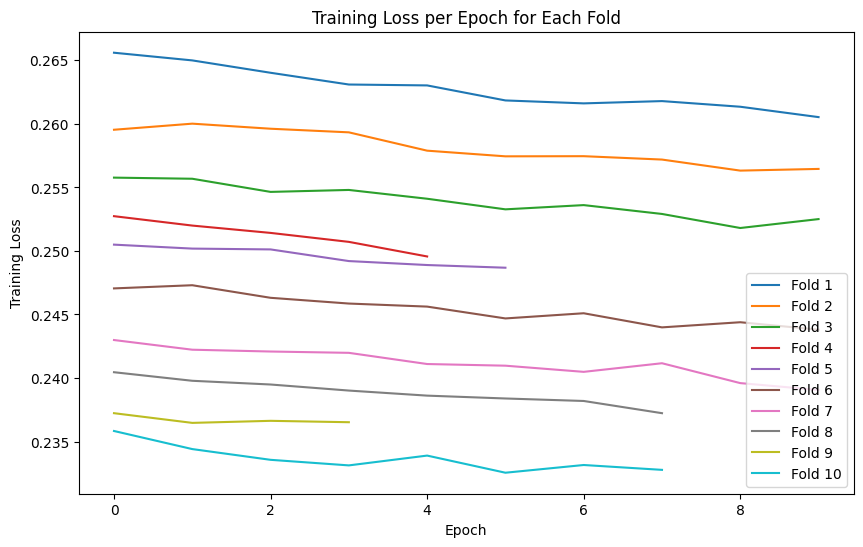

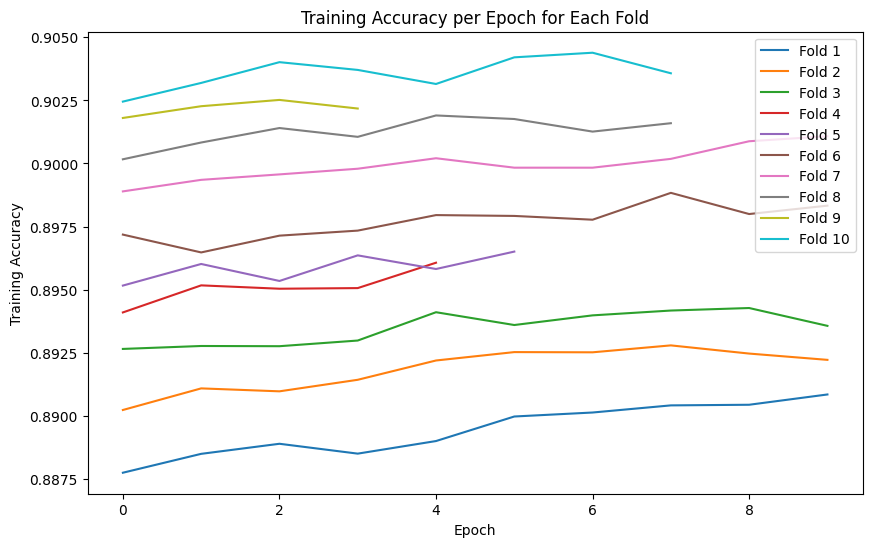

In [75]:
plt.figure(figsize=(10, 6))
for fold_num, fold_loss in enumerate(train_loss_history):
    plt.plot(fold_loss, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Epoch for Each Fold')
plt.legend()
plt.savefig(f'./graphs/10_tlm_peq_fine_tuning_mlp_loss_train_04.png')
plt.show()

plt.figure(figsize=(10, 6))
for fold_num, fold_accuracy in enumerate(train_accuracy_history):
    plt.plot(fold_accuracy, label=f'Fold {fold_num+1}')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Epoch for Each Fold')
plt.legend()
plt.savefig(f'./graphs/10_tlm_peq_fine_tuning_mlp_accuracy_train_04.png')
plt.show()

In [51]:
test_loss, test_accuracy = model.evaluate(X_test_tensor, y_test_tensor)

43/43 [==============================] - 0s 8ms/step - loss: 0.1401 - accuracy: 0.9493
